In [ ]:
import tensorflow as tf
!nvidia-smi
print(tf.test.gpu_device_name())

Wed Sep  7 15:10:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
tf.device('/device:GPU:0')

In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:
%%bash
cd /content/drive/MyDrive/CYOBOT/UNET
# [ ! -d dataset ] && mkdir dataset
# mv train dataset/
# mv train_label dataset/
# mv val dataset/
# mv val_label dataset/

In [17]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfl

!pip install focal-loss
from focal_loss import SparseCategoricalFocalLoss

import imageio
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
IMAGE_SIZE = (96, 128)
INITIAL_FILTER_NUM = 64
CLASS_NUM = 3
BATCH_SIZE = 8
BUFFER_SIZE = 500
EPOCH_NUM = 40

#Create checkpoint folder
checkpoint_folder = "/content/drive/MyDrive/CYOBOT/UNET/training_checkpoint"
![ ! -d $checkpoint_folder ] && mkdir -p $checkpoint_folder

CHECKPOINT_PATH = os.path.join(checkpoint_folder, "checkpoint.ckpt")
img_path = "/content/drive/MyDrive/CYOBOT/UNET/dataset/train/"
mask_path = "/content/drive/MyDrive/CYOBOT/UNET/dataset/train_label/"

val_img_path = "/content/drive/MyDrive/CYOBOT/UNET/dataset/val/"
val_mask_path = "/content/drive/MyDrive/CYOBOT/UNET/dataset/val_label/"

In [19]:
def process_path(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels= 3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis = -1, keepdims= True)
    
    return img, mask

def preprocess_dataset(img, mask):
    #Resize the dataset to IMAGE_SIZE
    img = tf.image.resize(img, size = IMAGE_SIZE, method = 'nearest')
    mask = tf.image.resize(mask, size = IMAGE_SIZE, method = 'nearest')
    # #Convert mask to one-hot encoding
    # tf.cast(mask, tf.uint8)
    # mask = tf.one_hot(mask, CLASS_NUM)
    
    return img, mask

In [20]:
def downsampling_block(input, filters_num, dropout_rate = 0, max_pooling = False):
    '''
    This function will serve as a downsampling bnlock in the unet. It has 2 convolution layer, 1 dropout layer, and 1 max pooling layer (optional)
    Return the tensor before doing the last maxpooling (for the skip connection) and the tensor after doing pooling
    '''
    model = keras.Sequential(
        [tfl.Conv2D(filters= filters_num, kernel_size=3,
                    kernel_initializer='he_normal', padding='same', activation = 'relu'),
         tfl.Conv2D(filters= filters_num, kernel_size=3,
                    kernel_initializer='he_normal', padding='same', activation = 'relu'),
         tfl.Dropout(rate = dropout_rate)
         ])
    next_block = before_pooling = model(input)
    if max_pooling:
        next_block = tfl.MaxPool2D(pool_size=(2,2), strides=2)(before_pooling)
    return next_block, before_pooling

def upsampling_block(expansive_tensor, contractive_tensor, filters_num):
    contractive_tensor = tfl.Conv2DTranspose(filters = filters_num, kernel_size=3,
                                             strides = (2,2), padding = 'same')(contractive_tensor)
    input = tfl.Concatenate(axis = 3)([expansive_tensor, contractive_tensor])
    
    model = keras.Sequential([
        tfl.Conv2D(filters= filters_num, kernel_size=3, padding = 'same', activation='relu',
                   kernel_initializer='he_normal'),
        tfl.Conv2D(filters=filters_num, kernel_size=3, padding='same', activation='relu',
                   kernel_initializer='he_normal')
    ])
    output = model(input)
    return output

def unet_architecture(input_size, initial_filters_num, n_classes):
    #Building U-Net based on the upsampling block and downsampling block
    input = keras.Input(shape=input_size)
    dropout_rate = 0.3

    #Downsampling the tensor
    down1, skip1 = downsampling_block(input, initial_filters_num * 1, dropout_rate, True)
    down2, skip2 = downsampling_block(down1, initial_filters_num * 2, dropout_rate, True)
    down3, skip3 = downsampling_block(down2, initial_filters_num * 4, dropout_rate, True)
    down4, skip4 = downsampling_block(down3, initial_filters_num * 8, dropout_rate, True)
    down5, skip5 = downsampling_block(down4, initial_filters_num * 16, dropout_rate, True)

    #Upsampling the tensor
    up4 = upsampling_block(skip4, skip5, initial_filters_num * 8)
    up3 = upsampling_block(skip3, up4, initial_filters_num * 4)
    up2 = upsampling_block(skip2, up3, initial_filters_num * 2)
    up1 = upsampling_block(skip1, up2, initial_filters_num * 1)

    last_layers = keras.Sequential([
        tfl.Conv2D(initial_filters_num, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal'),
        tfl.Conv2D(n_classes, kernel_size=1, padding='same')
    ])
    output = last_layers(up1)

    model = keras.Model(input, output)
    return model

In [21]:
class PlotLearning(keras.callbacks.ModelCheckpoint):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.first_epoch = None

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)

        

        if self.first_epoch is None:
          self.first_epoch = epoch
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        clear_output(wait=True)
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        fig, axes = plt.subplots(1, 2, figsize=(15,5))

        for i, metric in enumerate(metrics):
            if 'loss' in metric:
                axes[0].plot(range(self.first_epoch+1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
                if logs['val_' + metric]:
                    axes[0].plot(range(self.first_epoch+1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                axes[0].set(xlabel="Epoch num")
                axes[0].legend()
            else:
                axes[1].plot(range(self.first_epoch+1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
                if logs['val_' + metric]:
                    axes[1].plot(range(self.first_epoch+1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
                axes[1].set(xlabel="Epoch num")
                axes[1].legend()
        plt.grid()
        plt.tight_layout()
        plt.show()
        fig.savefig(os.path.join(checkpoint_folder, f"plot.png"))

In [38]:
img_list = os.listdir(img_path)
mask_list = [mask_path + img_dir[:-4] + '_label.png' for img_dir in img_list]
img_list = [img_path + img_dir for img_dir in img_list]

val_img_list = os.listdir(val_img_path)
val_mask_list = [val_mask_path + val_img_dir[:-4] + '_label.png' for val_img_dir in val_img_list]
val_img_list = [val_img_path + val_img_dir for val_img_dir in val_img_list]


In [39]:
#Turn the dataset to tensor
img_list_tf = tf.constant(img_list)
mask_list_tf = tf.constant(mask_list)
dataset = tf.data.Dataset.from_tensor_slices((img_list_tf, mask_list_tf))

dataset = dataset.map(process_path)
dataset = dataset.map(preprocess_dataset)

dataset = dataset.prefetch(tf.data.AUTOTUNE)

#Do the same for val dataset
val_img_list_tf = tf.constant(val_img_list)
val_mask_list_tf = tf.constant(val_mask_list)
val_dataset = tf.data.Dataset.from_tensor_slices((val_img_list_tf, val_mask_list_tf))

val_dataset = val_dataset.map(process_path)
val_dataset = val_dataset.map(preprocess_dataset)

dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [24]:
# photo_show = 3
# fig, ax = plt.subplots(photo_show,2, figsize=(25,20))
# i = 0
# for x, y in dataset.take(photo_show):
#   print(np.shape(x))
#   ax[i, 0].imshow(x)
#   print(np.unique(y))
#   ax[i, 1].imshow(y[:,:,0])
#   i+=1

In [25]:
# photo_show = 3
# fig, ax = plt.subplots(photo_show,2, figsize=(25,20))
# i = 0
# for x, y in val_dataset.take(photo_show):
#   print(np.shape(x))
#   ax[i, 0].imshow(x)
#   print(np.unique(y))
#   ax[i, 1].imshow(y[:,:,0])
#   i+=1

In [26]:
class CustomMeanIOU(tf.keras.metrics.MeanIoU):
  def __init__(self, name, num_class):
    super(CustomMeanIOU,self).__init__(num_class)
  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = y_pred[..., tf.newaxis]
    # print(y_true)
    # print(y_pred)
    super().update_state(y_true, y_pred, sample_weight)

In [27]:
input_shape = IMAGE_SIZE + (3,)

unet = unet_architecture(input_shape, INITIAL_FILTER_NUM, CLASS_NUM)
unet.summary()

#Set up the specs for compile
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = SparseCategoricalFocalLoss(gamma = 2.0, from_logits=True)
metrics = [CustomMeanIOU(num_class=3, name='customMeanIOU')]

unet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(CHECKPOINT_PATH)
cp_callback = PlotLearning(filepath=CHECKPOINT_PATH,
                                            save_weights_only=True,
                                            verbose = 1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential (Sequential)        (None, 96, 128, 64)  38720       ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 64)   0           ['sequential[0][0]']             
                                                                                                  
 sequential_1 (Sequential)      (None, 48, 64, 128)  221440      ['max_pooling2d[0][0]']      

In [28]:
# history = unet.fit(dataset, epochs=EPOCH_NUM, callbacks=[cp_callback, reduce_lr], validation_data=val_dataset)

In [35]:
def process_prediction_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

def show_prediction_and_true_mask(model, dataset, num = 2):
  fig, axes = plt.subplots(BATCH_SIZE, num*3, figsize = (20,20))
  idx = 0
  for img, mask in dataset.take(num):
    print(type(img))
    prediction = model.predict(img)
    
    prediction = process_prediction_mask(prediction[idx])
    img = img[idx]
    mask = mask[idx]

    for i in range(BATCH_SIZE):
      axes[i, 0 + idx*3].set_title("Image")
      axes[i, 0 + idx*3].imshow(keras.preprocessing.image.array_to_img(img))
      axes[i, 0 + idx*3].axis("off")
    
      axes[i, 1 + idx*3].set_title("True mask")
      axes[i, 1 + idx*3].imshow(keras.preprocessing.image.array_to_img(mask))
      axes[i, 1 + idx*3].axis("off")

      axes[i, 2 + idx*3].set_title("Predicted_mask")
      axes[i, 2 + idx*3].imshow(keras.preprocessing.image.array_to_img(prediction))
      axes[i, 2 + idx*3].axis("off")
    idx+=1
      
  plt.show()

In [36]:
unet.load_weights('/content/drive/MyDrive/CYOBOT/UNET/training_checkpoint/checkpoint.ckpt')

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


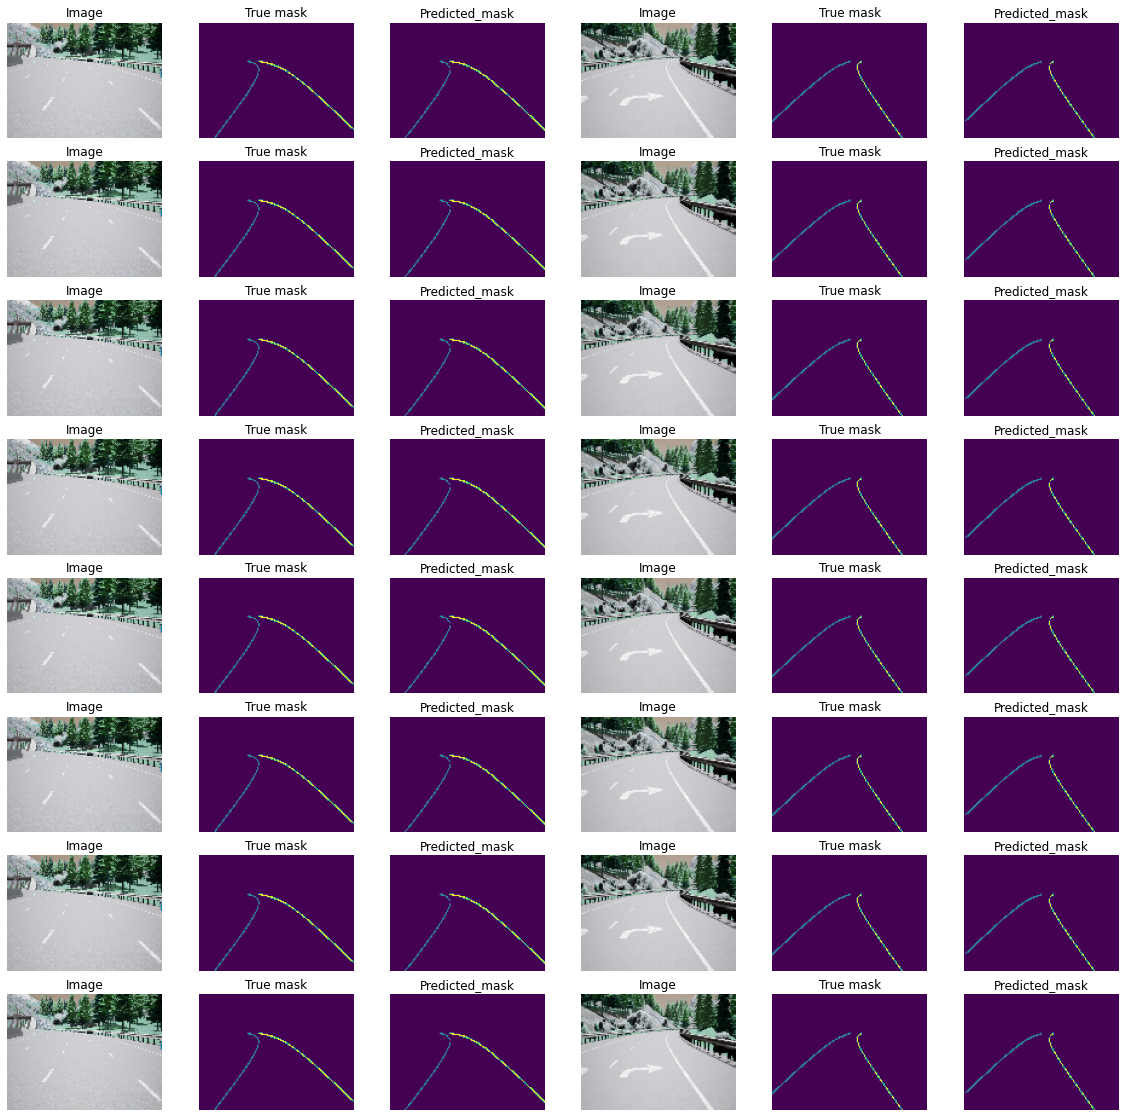

In [37]:
show_prediction_and_true_mask(unet, val_dataset, 2)

In [40]:
result = unet.evaluate(val_dataset)

17/17 [==============================] - 4s 47ms/step - loss: 0.0024 - custom_mean_iou: 0.8569


In [32]:
from collections import defaultdict
#Build video feed
val_img_list = os.listdir(val_img_path)[:20]

prefix2img = defaultdict(list)
for file in val_img_list:
  components = file.split('_')
  prefix2img[(tuple(components[3:9]))].append(file)
def sort_key(elem):
  components = elem.split('_')
  return int(components[10])
for prefix in prefix2img.keys():
  prefix2img[prefix].sort(key=sort_key)
print(prefix2img)

defaultdict(<class 'list'>, {('09', '09', '2020', '14', '57', '22'): ['Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_102_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_107_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_116_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_144_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_1059_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_1061_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_1109_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_1171_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_1172_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_1197_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_1198_validation_set.png', 'Town04_Clear_Noon_09_09_2020_14_57_22_frame_1199_validation_set.png', 'Town04_Clea

Time for each frame: 0.0907440185546875


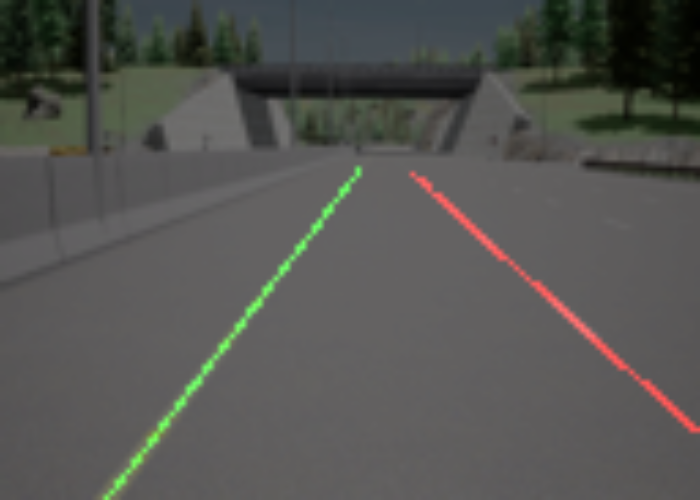

In [34]:
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image, ImageEnhance
from time import time

for video in prefix2img.keys():
  for frame_name in prefix2img[video]:
    frame = Image.open(os.path.join(val_img_path, frame_name)).resize(IMAGE_SIZE[::-1])
    frame_arr = np.asarray(frame)
    frame_arr = np.expand_dims(frame_arr, axis = 0)
    start = time()
    predicted_label = unet.predict(frame_arr)[0]
    end = time()
    predicted_label = predicted_label.max(axis=-1,keepdims=1) == predicted_label
    
    predicted_label = predicted_label * [0,255,255]
    disp_img = cv2.addWeighted(frame_arr[0].astype(np.uint8),0.5,predicted_label.astype(np.uint8),0.7,0)
    clear_output()
    print(f'Time for each frame: {end - start}')
    cv2_imshow(cv2.resize(disp_img, (700,500)))


